In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pickle
from copy import deepcopy

In [2]:
def load_pickle(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return data

def save_pickle(data, path):
    with open(path, 'wb') as f:
        pickle.dump(data, f)

def get_image_id(image_id):
    image_id = str(image_id)
    if len(image_id) == 6 and image_id.isdigit():
        return image_id
    return f"{int(image_id):06}"

def make_path(ROOT, category, dataset, split, image_id, file=''):
    image_id = get_image_id(image_id)
    image_path = os.path.join(*[ROOT, f'{category}/{dataset}/{split}/{image_id}', file])
    return image_path
    
def extract_image_stats(data):
    return {
        'height': data['dims'][0], 
        'width': data['dims'][1], 
        'avg_ilg': data['avg_interline_gap'], 
        'n_line': len(data['all_gaps'])
    }

def get_image_stats(ROOT, category, dataset, split, image_id):
    file = 'result.pkl'
    path = make_path(ROOT, category, dataset, split, image_id, file)
    data = load_pickle(path)
    image_stats = extract_image_stats(data)
    return image_stats

In [3]:
def get_dataset_stats(category, dataset):
    dataset_dir = os.path.join(RESULTS_ROOT, f'{category}/{dataset}')
    dataset_stats = {}
    for split in os.listdir(dataset_dir): #for each split in train, test, val
        dataset_stats[split] = []
        split_path = os.path.join(*[dataset_dir, split])
        for image in os.listdir(split_path): # for each image path like 000010
            try:
                image_stats = get_image_stats(RESULTS_ROOT, category, dataset, split, image)
                dataset_stats[split].append(image_stats)
            except Exception as e:
                error_list1.append([category, dataset, split, image, repr(e)])
    return dataset_stats

def compute_dataset_level_stats(stats):
    dataset_level_stats = {}
    st = {
        'heights': [], 
        'widths': [], 
        'avg_ilgs': [], 
        'n_lines': []
    }

    dataset_level_stats['all_splits'] = deepcopy(st)
    for split in stats.keys():
        dataset_level_stats[split] = deepcopy(st)
        for image in stats[split]:
            dataset_level_stats['all_splits']['heights'].append(image['height'])
            dataset_level_stats[split]['heights'].append(image['height'])

            dataset_level_stats['all_splits']['widths'].append(image['width'])
            dataset_level_stats[split]['widths'].append(image['width'])

            dataset_level_stats['all_splits']['avg_ilgs'].append(image['avg_ilg'])
            dataset_level_stats[split]['avg_ilgs'].append(image['avg_ilg'])

            dataset_level_stats['all_splits']['n_lines'].append(image['n_line'])
            dataset_level_stats[split]['n_lines'].append(image['n_line'])
    result = {}
    
    for split in dataset_level_stats.keys():
        try:
            result[split] = {}
            result[split]['avg_height'] = round(np.mean(dataset_level_stats[split]['heights']))
            result[split]['avg_width'] = round(np.mean(dataset_level_stats[split]['widths']))
            result[split]['avg_ilg'] = round(np.mean(dataset_level_stats[split]['avg_ilgs']))
            result[split]['n_line'] = round(np.mean(dataset_level_stats[split]['n_lines']))
        except Exception as e:
            error_list2.append([category, dataset, split, repr(e)])
            result[split]['avg_height'] = 0
            result[split]['avg_width'] = 0
            result[split]['avg_ilg'] = 0
            result[split]['n_line'] = 0

    return result


global RESULTS_ROOT, IMAGES_ROOT
global error_list1, error_list2
error_list1, error_list2 = [], []
RESULTS_ROOT = '/data3/vaibhav.agrawal/SegmentAnyLine/SAL-Datasets/results/'
IMAGES_ROOT = '/data3/vaibhav.agrawal/SegmentAnyLine/SAL-Datasets/datasets/'

# category, dataset = 'arabic', 'moc'
# stats = get_dataset_stats(category, dataset)
# dataset_level_stats = compute_dataset_level_stats(stats)

In [6]:
stats_for_all_datasets = {}
for category in os.listdir(RESULTS_ROOT):
    stats_for_all_datasets[category] = {}
    for dataset in os.listdir(os.path.join(*[RESULTS_ROOT, category])):
        if os.path.isdir(os.path.join(*[RESULTS_ROOT, category, dataset])): # some folders have some .zip files
            stats = get_dataset_stats(category, dataset)
            save_pickle(stats, f'../outputs/dataset_wise/{dataset}_stats.pkl')
            dataset_level_stats = compute_dataset_level_stats(stats)
            save_pickle(dataset_level_stats, f'../outputs/dataset_wise/{dataset}_dataset_level_stats.pkl')
            stats_for_all_datasets[category][dataset] = dataset_level_stats
        
save_pickle(stats_for_all_datasets, '../outputs/stats_for_all_datasets.pkl')

/home/user/anaconda3/envs/amalj/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/anaconda3/envs/amalj/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [7]:
stats_for_all_datasets['palm_leaves']['WM']

{'all_splits': {'avg_height': 0, 'avg_width': 0, 'avg_ilg': 0, 'n_line': 0},
 'test': {'avg_height': 0, 'avg_width': 0, 'avg_ilg': 0, 'n_line': 0}}

## Checking ErrorList

In [37]:
len(error_list1), len(error_list2)

(1677, 8)

In [ ]:
import pandas as pd

df = pd.DataFrame(error_list1, columns=['category', 'dataset', 'split', 'image', 'error'])
df.to_csv('dataset_error_list.csv', index=False)
df.head()

In [56]:
df.dataset.unique()

array(['DrosB', 'ChallengingHandwritten', 'I2', 'BKS', 'UB', 'KG', 'WM',
       'SM', 'bozen', 'ICDAR2017cBAD_Complex', 'ICDAR2019cBAD',
       'ICDAR2017cBAD_Simple', 'X_53', 'pinkas'], dtype=object)

In [57]:
df[df['dataset'] == 'bozen']

,category,dataset,split,image,error
244,english,bozen,train,000108,"FileNotFoundError(2, 'No such file or directory')"
245,english,bozen,train,000053,"FileNotFoundError(2, 'No such file or directory')"
246,english,bozen,train,000017,"FileNotFoundError(2, 'No such file or directory')"
247,english,bozen,train,000304,"FileNotFoundError(2, 'No such file or directory')"
248,english,bozen,train,000314,"FileNotFoundError(2, 'No such file or directory')"
249,english,bozen,train,000162,"FileNotFoundError(2, 'No such file or directory')"
250,english,bozen,train,000289,"FileNotFoundError(2, 'No such file or directory')"
251,english,bozen,train,000210,"FileNotFoundError(2, 'No such file or directory')"
252,english,bozen,train,000122,"FileNotFoundError(2, 'No such file or directory')"
253,english,bozen,train,000261,"FileNotFoundError(2, 'No such file or directory')"


In [63]:
df2 = pd.DataFrame(error_list2, columns=['category', 'dataset', 'split', 'error'])
df2

,category,dataset,split,error
0,palm_leaves,UB,all_splits,ValueError('cannot convert float NaN to integer')
1,palm_leaves,UB,test,ValueError('cannot convert float NaN to integer')
2,palm_leaves,KG,test,ValueError('cannot convert float NaN to integer')
3,palm_leaves,WM,all_splits,ValueError('cannot convert float NaN to integer')
4,palm_leaves,WM,test,ValueError('cannot convert float NaN to integer')
5,palm_leaves,SM,all_splits,ValueError('cannot convert float NaN to integer')
6,palm_leaves,SM,test,ValueError('cannot convert float NaN to integer')
7,english,ICDAR2017cBAD_Complex,test,ValueError('cannot convert float NaN to integer')


## Load Dataset Stats

In [8]:
all_dataset_stats = load_pickle('../outputs/stats_for_all_datasets.pkl')

In [9]:
all_dataset_stats['french']

{'HLE-Text_Multiscripts_FR': {'all_splits': {'avg_height': 358,
   'avg_width': 631,
   'avg_ilg': 46,
   'n_line': 10},
  'train': {'avg_height': 358, 'avg_width': 631, 'avg_ilg': 46, 'n_line': 10}},
 'DrosB': {'all_splits': {'avg_height': 3018,
   'avg_width': 4201,
   'avg_ilg': 106,
   'n_line': 33},
  'train': {'avg_height': 3018,
   'avg_width': 4201,
   'avg_ilg': 106,
   'n_line': 33}}}

In [10]:
all_dataset_stats

{'french': {'HLE-Text_Multiscripts_FR': {'all_splits': {'avg_height': 358,
    'avg_width': 631,
    'avg_ilg': 46,
    'n_line': 10},
   'train': {'avg_height': 358,
    'avg_width': 631,
    'avg_ilg': 46,
    'n_line': 10}},
  'DrosB': {'all_splits': {'avg_height': 3018,
    'avg_width': 4201,
    'avg_ilg': 106,
    'n_line': 33},
   'train': {'avg_height': 3018,
    'avg_width': 4201,
    'avg_ilg': 106,
    'n_line': 33}}},
 'arabic': {'moc': {'all_splits': {'avg_height': 3711,
    'avg_width': 2758,
    'avg_ilg': 72,
    'n_line': 52},
   'train': {'avg_height': 3672,
    'avg_width': 2752,
    'avg_ilg': 72,
    'n_line': 47},
   'test': {'avg_height': 3795,
    'avg_width': 2772,
    'avg_ilg': 73,
    'n_line': 64}},
  'RASM2019': {'all_splits': {'avg_height': 7042,
    'avg_width': 4986,
    'avg_ilg': 236,
    'n_line': 24},
   'train': {'avg_height': 7042,
    'avg_width': 4986,
    'avg_ilg': 236,
    'n_line': 24}},
  'AHTE': {'all_splits': {'avg_height': 3767,
    'avg

In [14]:
import pandas as pd

flattened_data = []

for category, datasets in all_dataset_stats.items():
    for dataset, splits in datasets.items():
        for split_name, stats in splits.items():
            # Add a row for each split
            flattened_data.append({
                "category": category,
                "dataset": dataset,
                "split": split_name,
                **stats  # Unpack the stats dictionary into columns
            })

# Convert to a pandas DataFrame
df = pd.DataFrame(flattened_data)
df.to_csv('../outputs/flat_all_dataset_stats.csv', index=False)

# Display the DataFrame
df

,category,dataset,split,avg_height,avg_width,avg_ilg,n_line
0,french,HLE-Text_Multiscripts_FR,all_splits,358,631,46,10
1,french,HLE-Text_Multiscripts_FR,train,358,631,46,10
2,french,DrosB,all_splits,3018,4201,106,33
3,french,DrosB,train,3018,4201,106,33
4,arabic,moc,all_splits,3711,2758,72,52
...,...,...,...,...,...,...,...
85,chinese,M5HisDoc_regular,train,2189,2388,98,49
86,chinese,M5HisDoc_regular,test,2141,2324,93,50
87,chinese,M5HisDoc_regular,val,2150,2378,93,48
88,chinese,HLE-Text_Multiscripts_CHI,all_splits,753,822,68,10


In [15]:
df[df['dataset'] == 'RASM2019']

,category,dataset,split,avg_height,avg_width,avg_ilg,n_line
7,arabic,RASM2019,all_splits,7042,4986,236,24
8,arabic,RASM2019,train,7042,4986,236,24


In [ ]:
def save_stats_as_csv(stats):
    for category in stats.keys()

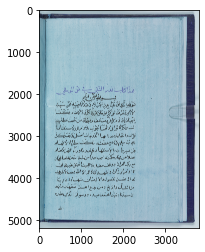

In [19]:
path = '/data3/vaibhav.agrawal/SegmentAnyLine/SAL-Datasets/datasets/arabic/RASM2019/train/000000.jpg'
img = cv2.imread(path)
plt.imshow(img)

In [27]:
path = '/data3/vaibhav.agrawal/SegmentAnyLine/SAL-Datasets/datasets/arabic/RASM2019/train/'
os.path.exists(path)


True

In [28]:
os.listdir(path)

['remove',
 '000042.jpg',
 '000039.pkl',
 '000018.pkl',
 '000054.jpg',
 '000031.jpg',
 '000011.pkl',
 '000000.pkl',
 '000019.jpg',
 '000050.pkl',
 '000004.jpg',
 '000033.pkl',
 '000021.pkl',
 '000005.jpg',
 '000006.pkl',
 '000058.jpg',
 '000051.pkl',
 '000023.jpg',
 '000002.pkl',
 '000045.jpg',
 '000043.pkl',
 '000056.pkl',
 '000003.jpg',
 '000029.jpg',
 '000056.jpg',
 '000028.pkl',
 '000022.jpg',
 '000028.jpg',
 '000000.jpg',
 '000002.jpg',
 '000037.pkl',
 '000034.jpg',
 '000050.jpg',
 'reannotate',
 '000021.jpg',
 '000029.pkl',
 '000011.jpg',
 '000009.jpg',
 '000023.pkl',
 '000020.pkl',
 '000015.jpg',
 '000022.pkl',
 '000017.jpg',
 '000044.pkl',
 '000008.pkl',
 '000012.pkl',
 '000051.jpg',
 '000042.pkl',
 '000004.pkl',
 '000001.pkl',
 '000025.jpg',
 '000033.jpg',
 '000001.jpg',
 '000013.pkl',
 '000013.jpg',
 '000010.pkl',
 '000038.pkl',
 '000020.jpg',
 '000014.pkl',
 '000012.jpg',
 '000053.pkl',
 '000010.jpg',
 '000052.pkl',
 '000035.pkl',
 '000046.jpg',
 '000057.pkl',
 '000030.pkl',

In [ ]:
import os
import numpy as np


IMAGES_ROOT = '/data3/vaibhav.agrawal/SegmentAnyLine/SAL-Datasets/datasets/'
category, dataset = 'arabic', 'RASM2019'

def get_dataset_count_info(category, dataset):
    dataset_count_info = {}
    dataset_dir = os.path.join(*[IMAGES_ROOT, f'{category}/{dataset}/'])
    splits = os.listdir(dataset_dir)
    for split in splits:
        images = [image for image in os.listdir(os.path.join(*[dataset_dir, split])) if image.endswith('.jpg')]
        try:
            images.extend([image for image in os.listdir(os.path.join(*[dataset_dir, split, 'reannotate'])) if image.endswith('.jpg')])
        except:
            pass
        dataset_count_info[split] = len(images)
    dataset_count_info['all_splits'] = sum([count for count in dataset_stat.values()])
    return dataset_count_info
for cate
get_dataset_count_info(category, dataset)
    

{'train': 60, 'all_splits': 30}

30